# MNIST with Naive Bayes

In this section, I will use a Naive Bayes classifier to distinguish between handwritten digits.  I will use a simple Bernoulli model of binary pixels.  **For this section, I would implement the algorithms myself, do not use an existing python library.**

I will use the MNIST dataset. The code below reads in the MNIST dataset, which consists of 70,000 images of digits.  These are 28x28 images flattened into a 784 element vector.

In [1]:
# !pip install scikit-learn

In [2]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import pandas as pd
from skimage import data

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

The images will be found in mnist.data, and the labels in mnist.target

**a**. Split this data into a training and test set.

In [4]:
# Split images and labels into training and test sets
from sklearn.model_selection import train_test_split

X = mnist.data.to_numpy() # features
y = mnist.target.to_numpy() # labels from 0 to 9 (type: str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000
)

**b**. Plot 5 examples of each of the digits from the training data.

In [5]:
# Define a function to plot for each digit
def plot_digits(X_train, y_train, selected_digit):
    # get index for specific digit
    indices = np.where(y_train == selected_digit)[0][:5] # get the indices for the first 5 images
    
    # Plot the digit
    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=(5, 2))
    for i, index in enumerate(indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(X_train[index].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'5 Examples of digit {selected_digit}', fontsize='large', y=0.75)
    plt.tight_layout()
    plt.show

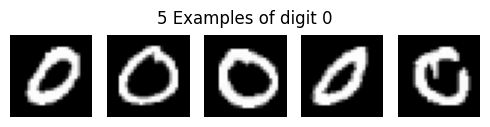

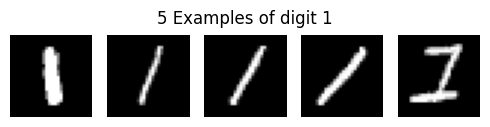

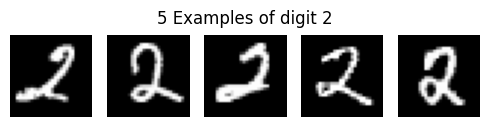

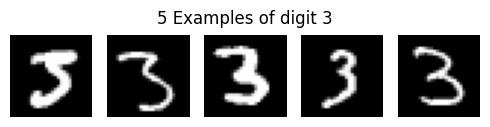

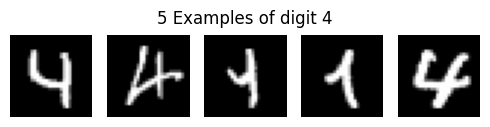

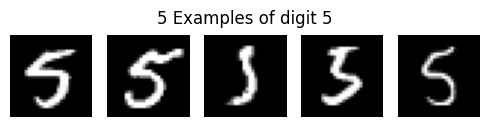

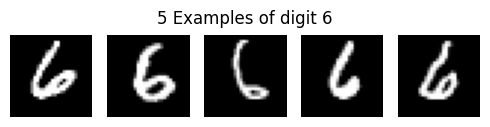

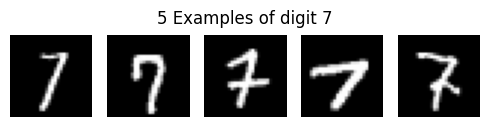

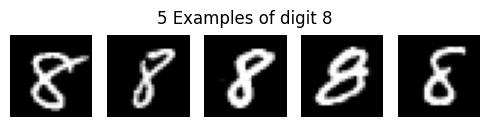

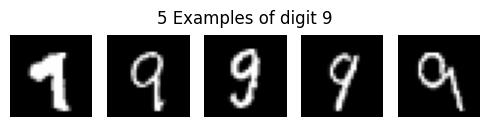

In [6]:
# Plot 5 examples for each digit
for i in range(10):
    plot_digits(X_train, y_train, str(i))

**c**. Using a Bernoulli model of each pixel, train a naive bayes model of the data (that is, just calculate the vector of pixel probabilities, for each digit). Add one pseudocount to each pixel for smoothing.

In [7]:
# Bernoulli model -> each pixel is either ON or OFF
# In this case, pixel = 0 is OFF, while pixel > 0 is ON

# Training:

# Break down training data to 10 classes of 0 - 9
def arrange_byClass(x, y):
    dataset_byClass = dict()
    for i in range(10):
        indices = np.where(y == str(i)[0]) # get indices to pinpoint in x
        dataset_byClass[i] = x[indices]  
    return dataset_byClass
### Return a dictionary where KEY is digit class in [0, 9] and VALUE is all pixels in an array belonging to the specific class

# Calculate P(Y = y) "priori" where y is in [0, 9] --> the probability of each digit class in the training data
def priori_calculation(y):
    occurance = [len(y[y==str(i)]) for i in range(10)]
    # print(occurance)
    prior_probs = {k: occurance[k]/(len(y)) for k in range(10)}
    # Check whether the sum of all probs is 1
    if sum(prior_probs.values()) == 1:
        print("The sum of priori probabilities is 1.")
    else:
        print("The sum of priori probabilities is NOT 1.")
        
    return prior_probs #  -> a dict arragned from 0 to 9

# Calculate Product of P(Xi = xtest,i | Y = y) over i where i is in [1, 784] and y is in [0,9] --> what is the probability of each pixel to be on
def condi_probs_calculation(x):
    conditional_probs = (np.sum(x > 0, axis=0) + 1) / (len(x) + 2*1)
    return conditional_probs # -> array[float]


def train_NB(X_train, y_train):
    group_dataset = arrange_byClass(X_train, y_train)
 
    priori = priori_calculation(y_train)
    likelihooods = []
    for digit_class, pixels_data in group_dataset.items():
        Conditional_probs = condi_probs_calculation(pixels_data) # shape (784,)
        likelihooods.append(Conditional_probs)

    return priori, np.array(likelihooods)

In [8]:
priori, likelihoods = train_NB(X_train, y_train)

The sum of priori probabilities is 1.


**d**. Calculate the observed proportions of each digit in the training data – these will be your priors. Make a plot to see what this distribution looks like.

In [9]:
plt.rcParams.get('font.size')

10.0

The sum of priori probabilities is 1.


<function matplotlib.pyplot.show(close=None, block=None)>

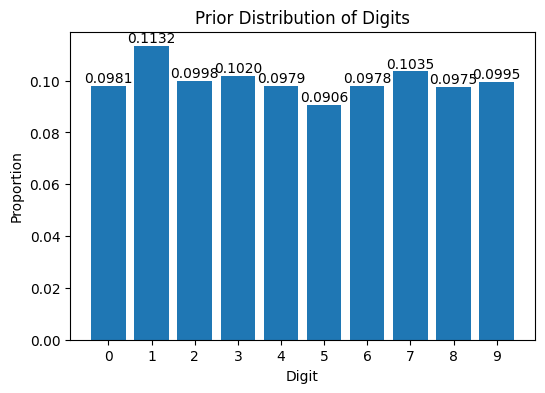

In [10]:
priori_calculation(y_train) # call the function

plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(6,4))
fig = plt.bar(x=priori.keys(), height=priori.values(), tick_label=np.arange(10))
plt.bar_label(fig, fmt='%.4f', padding=0.4)
plt.title('Prior Distribution of Digits')
plt.xlabel('Digit')
plt.ylabel('Proportion')
plt.show

**e**. Using your model, predict the labels for the test data. Remember to work with log probabilities, and remember to consider the priors for each digit that come from the training data.

In [11]:
# Testing:
def binarization(x):
    x_Binarization = []
    for x_row in x:       
        x_Binarization.append(np.where(x_row==0, 0, 1))       
    return np.array(x_Binarization)

def maximum_posterior(row, priori, likelihood):
    # For each sample in test set, we will calculate 10 posterior for 10 classes in [0, 9]
    estimated_posteriors = []
    # iterate 10 classes to access prior and likelihood array for given specfic
    ## posterior = log(priori[0,9]) + the sum of log(estimated_likelihood) where estimated_likelihood = the sum of log(p(x=1)) and log(p(x=0))
    for i in range(10):  
        estimated_likelihood = np.where(row==0, 1-likelihood[i], likelihood[i]) # shape --> (784,)
        posterior = np.log(priori[i]) + np.sum(np.log(estimated_likelihood))
        estimated_posteriors.append(posterior)
    return np.argmax(estimated_posteriors) # each estimated_posterior has 10 posterior, return the index of maximum posterior
    
def prediction_NB(x, priori, likelihoods):
    X_test_Binarization = binarization(x)
    predict_digits = []
    # iterate each row in test set
    for each_row in X_test_Binarization:   
        pred_digit = maximum_posterior(each_row, priori, likelihoods) # to get the maximum posterior for each row
        predict_digits.append(pred_digit)
    return predict_digits # expect to return 10,000 predicted results

In [12]:
y_pred = prediction_NB(X_test, priori, likelihoods)

**f**. To assess the model, report the confusion matrix for the test data. Report the accuracy, sensitivity, and Specificity.

In [13]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

Confusion Matrix:


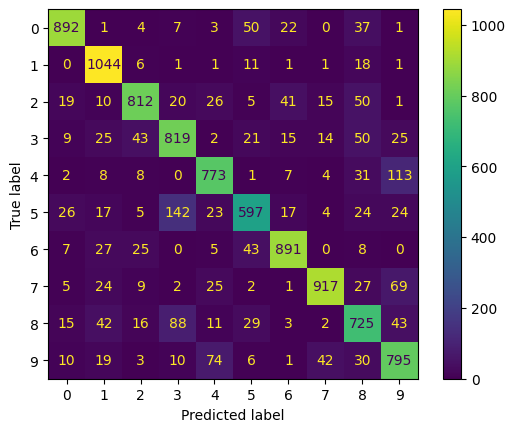

In [14]:
# Create the confusion matrix
y_true = y_test.astype(int)
cm = metrics.confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

plt.rcParams.update({'font.size': 10})
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.arange(10))
cm_display.plot()
print("Confusion Matrix:")
plt.show()

In [15]:
# Calculate accuracy
accuracy = metrics.accuracy_score(y_true, y_pred)
sensitivity_recall = metrics.recall_score(y_true, y_pred, average=None)

# Calculate sensitivity and specificity for each class
def calculate_specificity(cm, digit):
    TP = cm[digit, digit]
    TN = np.sum(cm) - np.sum(cm[digit, :]) - np.sum(cm[:, digit]) + TP
    FP = np.sum(cm[:, digit]) - TP
    FN = np.sum(cm[digit, :]) - TP
    specificity = TN / (TN + FP)
    return round(specificity, 8)

specificity = []
for digit in range(10):
    specificity.append(calculate_specificity(cm, digit))

print("Accuracy:", accuracy)
print("\nSensitivity for each digit:", sensitivity_recall)
print("\nSpecificity for each digit:", specificity)

Accuracy: 0.8265

Sensitivity for each digit: [0.87708948 0.96309963 0.81281281 0.80058651 0.81626188 0.67918089
 0.88568588 0.84828862 0.74435318 0.8030303 ]

Specificity for each digit: [0.98964711, 0.98059668, 0.98677925, 0.96992314, 0.98122169, 0.98158097, 0.98799199, 0.99080614, 0.96953246, 0.96925638]
